# Use map to generate tasks dynamically

The `map_` instruction in WorkGraph is conceptually similar to Python's built-in map function. In WorkGraph, the `map_` instruction spawns the tasks in the WorkGraph for each item in a dataset.

### Why use `map_`?

- **Creates dynamic tasks**: The number of tasks is determined at runtime based on input size.
- **Encapsulates child tasks**: All tasks inside a `map_` block are executed independently for each input item.

## Example: Running Tasks in Parallel with `map_`

Let's consider a simple workflow where we:
1. Generate a dictionary of numbers.
2. Add 1 to each number.
3. Multiply the result by 2.


In [1]:
from aiida_workgraph import task, WorkGraph, map_
from aiida import load_profile, orm

load_profile()

@task.calcfunction(outputs=["result"])
def generate_data(n: int) -> dict:
    """Generate a dictionary of integers."""
    result = {f"key_{i}": orm.Int(i) for i in range(n.value)}
    return {"result": result}

@task.calcfunction()
def add(x, y):
    return x + y

@task.calcfunction()
def multiply(x, y):
    return x * y

n = 3
wg = WorkGraph("map_example_1")
wg.add_task(generate_data, name="generate_data", n=n)
# Apply `map_` to distribute the workload
map_(wg.tasks.generate_data.outputs.result)(
    wg.add_task(add, name="add1", x=map_.default_placeholder, y=1),
    wg.add_task(multiply, name="multiply2", x=wg.tasks.add1.outputs.result, y=2),
)

# Show the WorkGraph
wg.to_html()
# wg


### 🔹 What happens here?
- `map_` **automatically applies** the tasks (`add1` and `multiply2`) to **each element** in the dictionary output of `generate_data`.
- Each instance of `add1` and `multiply2` **runs independently and in parallel**.
- The `default_placeholder` is a special reference that **ensures each element is mapped correctly**.


### Running and Checking Results


In [2]:
wg.run()
print("State of WorkGraph:   {}".format(wg.state))

03/09/2025 07:13:57 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:13:57 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: tasks ready to run: generate_data
03/09/2025 07:13:57 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|run_tasks]: Run task: generate_data, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'n': <Int: uuid: 0dcd5018-ebd0-4940-9a35-9fdf10ceb358 (pk: 42502) value: 3>}


03/09/2025 07:13:59 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|update_task_state]: Task: generate_data finished.
03/09/2025 07:13:59 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:13:59 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: tasks ready to run: map_1
03/09/2025 07:13:59 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|run_tasks]: Run task: map_1, type: MAP


------------------------------------------------------------
kwargs:  {'placeholder': 'map_input', 'source': AttributeDict({'key_0': <Int: uuid: 35538f96-158e-4fca-81cc-9564836af694 (pk: 42505) value: 0>, 'key_1': <Int: uuid: 7b610934-3a12-4a3e-b0be-d5351a17d3e4 (pk: 42506) value: 1>, 'key_2': <Int: uuid: f4c1aad9-8aac-4690-85cc-db3859a7c51e (pk: 42507) value: 2>})}


03/09/2025 07:13:59 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:13:59 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_add1,key_1_add1,key_2_add1
03/09/2025 07:13:59 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|run_tasks]: Run task: key_0_add1, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 35538f96-158e-4fca-81cc-9564836af694 (pk: 42505) value: 0>, 'y': 1}


03/09/2025 07:14:00 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|update_task_state]: Task: key_0_add1 finished.
03/09/2025 07:14:01 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:01 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_multiply2,key_1_add1,key_2_add1
03/09/2025 07:14:01 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|run_tasks]: Run task: key_0_multiply2, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'y': 2, 'x': <Int: uuid: 54356224-1fab-4bd0-be0b-11d670f426d2 (pk: 42510) value: 1>}


03/09/2025 07:14:02 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|update_task_state]: Task: key_0_multiply2 finished.
03/09/2025 07:14:02 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:02 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_1_add1,key_2_add1
03/09/2025 07:14:02 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|run_tasks]: Run task: key_1_add1, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 7b610934-3a12-4a3e-b0be-d5351a17d3e4 (pk: 42506) value: 1>, 'y': 1}


03/09/2025 07:14:03 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|update_task_state]: Task: key_1_add1 finished.
03/09/2025 07:14:03 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:03 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_1_multiply2,key_2_add1
03/09/2025 07:14:03 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|run_tasks]: Run task: key_1_multiply2, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'y': 2, 'x': <Int: uuid: efe018db-9fa0-481c-838a-d61549d1ad1b (pk: 42516) value: 2>}


03/09/2025 07:14:04 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|update_task_state]: Task: key_1_multiply2 finished.
03/09/2025 07:14:05 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:05 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_2_add1
03/09/2025 07:14:05 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|run_tasks]: Run task: key_2_add1, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: f4c1aad9-8aac-4690-85cc-db3859a7c51e (pk: 42507) value: 2>, 'y': 1}


03/09/2025 07:14:06 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|update_task_state]: Task: key_2_add1 finished.
03/09/2025 07:14:06 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|update_template_task_state]: Task: add1 finished.
03/09/2025 07:14:06 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:06 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_2_multiply2
03/09/2025 07:14:06 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|run_tasks]: Run task: key_2_multiply2, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'y': 2, 'x': <Int: uuid: 235ab554-0975-42f1-8799-3fbdabf99543 (pk: 42522) value: 3>}


03/09/2025 07:14:08 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|update_task_state]: Task: key_2_multiply2 finished.
03/09/2025 07:14:08 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|update_template_task_state]: Task: multiply2 finished.
03/09/2025 07:14:08 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|update_zone_task_state]: Task: map_1 finished.
03/09/2025 07:14:08 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:08 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
03/09/2025 07:14:08 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42503|WorkGraphEngine|finalize]: Finalize workgraph.


State of WorkGraph:   FINISHED


Generate node graph from the AiiDA process:

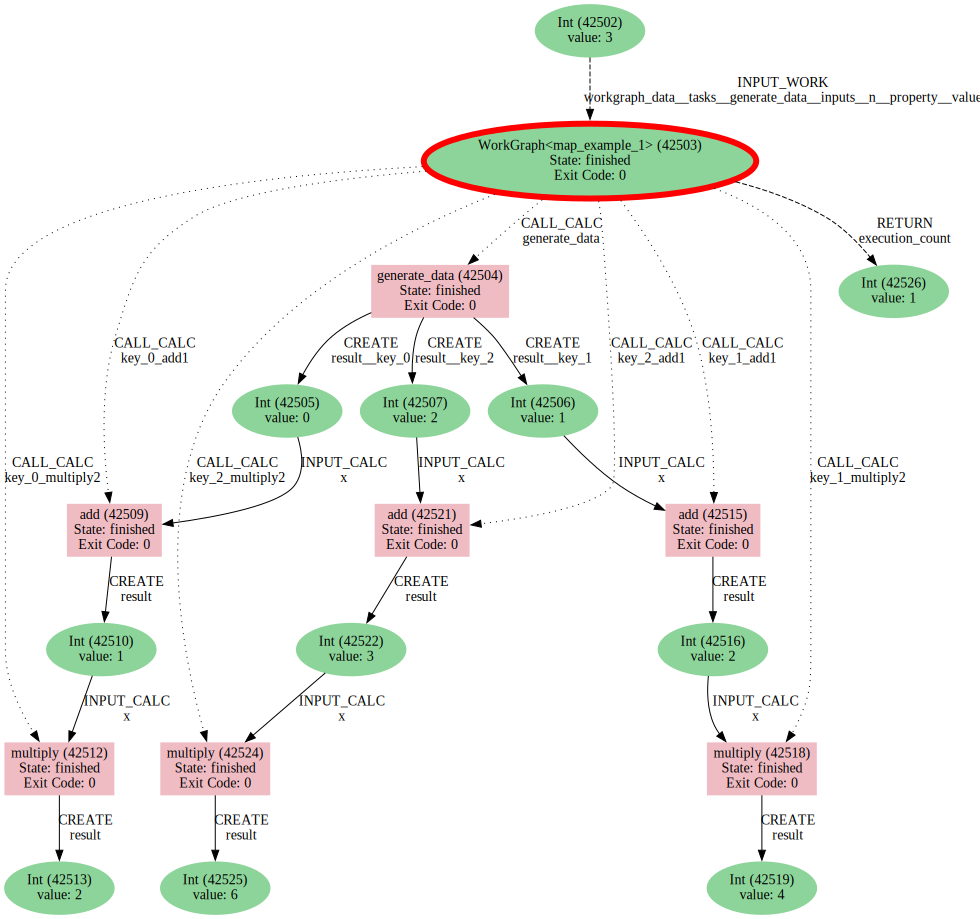

In [3]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Second workflow: gather results
Now I want to gather the results from the previous `multiply_parallel` tasks and calculate the sum of all their results.
Let's update the `multiply_parallel` function to `multiply_parallel_gather`.

In [4]:
@task.calcfunction()
def calc_sum(**datas) -> dict:
    """Compute the sum of all provided values."""
    return  sum(datas.values())

n = 3
wg = WorkGraph("map_example_2")
wg.add_task(generate_data, name="generate_data", n=n)
# Apply `map_` to distribute the workload
map_(wg.tasks.generate_data.outputs.result)(
    wg.add_task(add, name="add", x=map_.default_placeholder, y=1),
    wg.add_task(multiply, name="multiply", x=wg.tasks.add.outputs.result, y=2),
)
wg.add_task(calc_sum, name="calc_sum", datas=wg.tasks.multiply.outputs.result)
wg.to_html()

Run the workgraph and get the result of the tasks:

In [5]:
wg.run()
print("State of WorkGraph:   {}".format(wg.state))
print('Result of task add1: {}'.format(wg.tasks.calc_sum.outputs.result))

03/09/2025 07:14:15 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:15 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: tasks ready to run: generate_data
03/09/2025 07:14:15 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|run_tasks]: Run task: generate_data, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'n': <Int: uuid: 8895d041-65bc-4d29-b939-c26ee563f101 (pk: 42527) value: 3>}


03/09/2025 07:14:16 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|update_task_state]: Task: generate_data finished.
03/09/2025 07:14:16 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:16 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: tasks ready to run: map_1
03/09/2025 07:14:16 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|run_tasks]: Run task: map_1, type: MAP


------------------------------------------------------------
kwargs:  {'placeholder': 'map_input', 'source': AttributeDict({'key_0': <Int: uuid: 313c95d8-d323-4a02-9af0-7ba4e1a9902f (pk: 42530) value: 0>, 'key_1': <Int: uuid: 724375fa-04e4-4b67-8f6b-e39b79c2239b (pk: 42531) value: 1>, 'key_2': <Int: uuid: 16d2238a-1cd1-4c0a-8bf2-7377652edf03 (pk: 42532) value: 2>})}


03/09/2025 07:14:17 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:17 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_add,key_1_add,key_2_add
03/09/2025 07:14:17 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|run_tasks]: Run task: key_0_add, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 313c95d8-d323-4a02-9af0-7ba4e1a9902f (pk: 42530) value: 0>, 'y': 1}


03/09/2025 07:14:18 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|update_task_state]: Task: key_0_add finished.
03/09/2025 07:14:18 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:18 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_multiply,key_1_add,key_2_add
03/09/2025 07:14:18 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|run_tasks]: Run task: key_0_multiply, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'y': 2, 'x': <Int: uuid: cd483c53-2bf0-4c41-b05e-46dd04f8a184 (pk: 42535) value: 1>}


03/09/2025 07:14:20 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|update_task_state]: Task: key_0_multiply finished.
03/09/2025 07:14:20 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:20 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_1_add,key_2_add
03/09/2025 07:14:20 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|run_tasks]: Run task: key_1_add, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 724375fa-04e4-4b67-8f6b-e39b79c2239b (pk: 42531) value: 1>, 'y': 1}


03/09/2025 07:14:21 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|update_task_state]: Task: key_1_add finished.
03/09/2025 07:14:21 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:21 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_1_multiply,key_2_add
03/09/2025 07:14:21 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|run_tasks]: Run task: key_1_multiply, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'y': 2, 'x': <Int: uuid: a30cc15a-076c-48ca-b06d-d83a72b546e2 (pk: 42541) value: 2>}


03/09/2025 07:14:23 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|update_task_state]: Task: key_1_multiply finished.
03/09/2025 07:14:23 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:23 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_2_add
03/09/2025 07:14:23 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|run_tasks]: Run task: key_2_add, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 16d2238a-1cd1-4c0a-8bf2-7377652edf03 (pk: 42532) value: 2>, 'y': 1}


03/09/2025 07:14:24 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|update_task_state]: Task: key_2_add finished.
03/09/2025 07:14:25 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|update_template_task_state]: Task: add finished.
03/09/2025 07:14:25 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:25 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_2_multiply
03/09/2025 07:14:25 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|run_tasks]: Run task: key_2_multiply, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'y': 2, 'x': <Int: uuid: 5d09b75e-3be1-4cb1-9048-f74cf108c3fd (pk: 42547) value: 3>}


03/09/2025 07:14:26 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|update_task_state]: Task: key_2_multiply finished.
03/09/2025 07:14:27 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|update_template_task_state]: Task: multiply finished.
03/09/2025 07:14:27 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|update_zone_task_state]: Task: map_1 finished.
03/09/2025 07:14:27 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:27 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: tasks ready to run: calc_sum
03/09/2025 07:14:27 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|run_tasks]: Run task: cal

------------------------------------------------------------
kwargs:  {}


03/09/2025 07:14:28 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|update_task_state]: Task: calc_sum finished.
03/09/2025 07:14:28 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/09/2025 07:14:28 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
03/09/2025 07:14:28 AM <478764> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42528|WorkGraphEngine|finalize]: Finalize workgraph.


State of WorkGraph:   FINISHED
Result of task add1: SocketAny(name='result', value=uuid: 7d192dc3-bc17-4837-a2ff-4ba27f668861 (pk: 42552) value: 12)


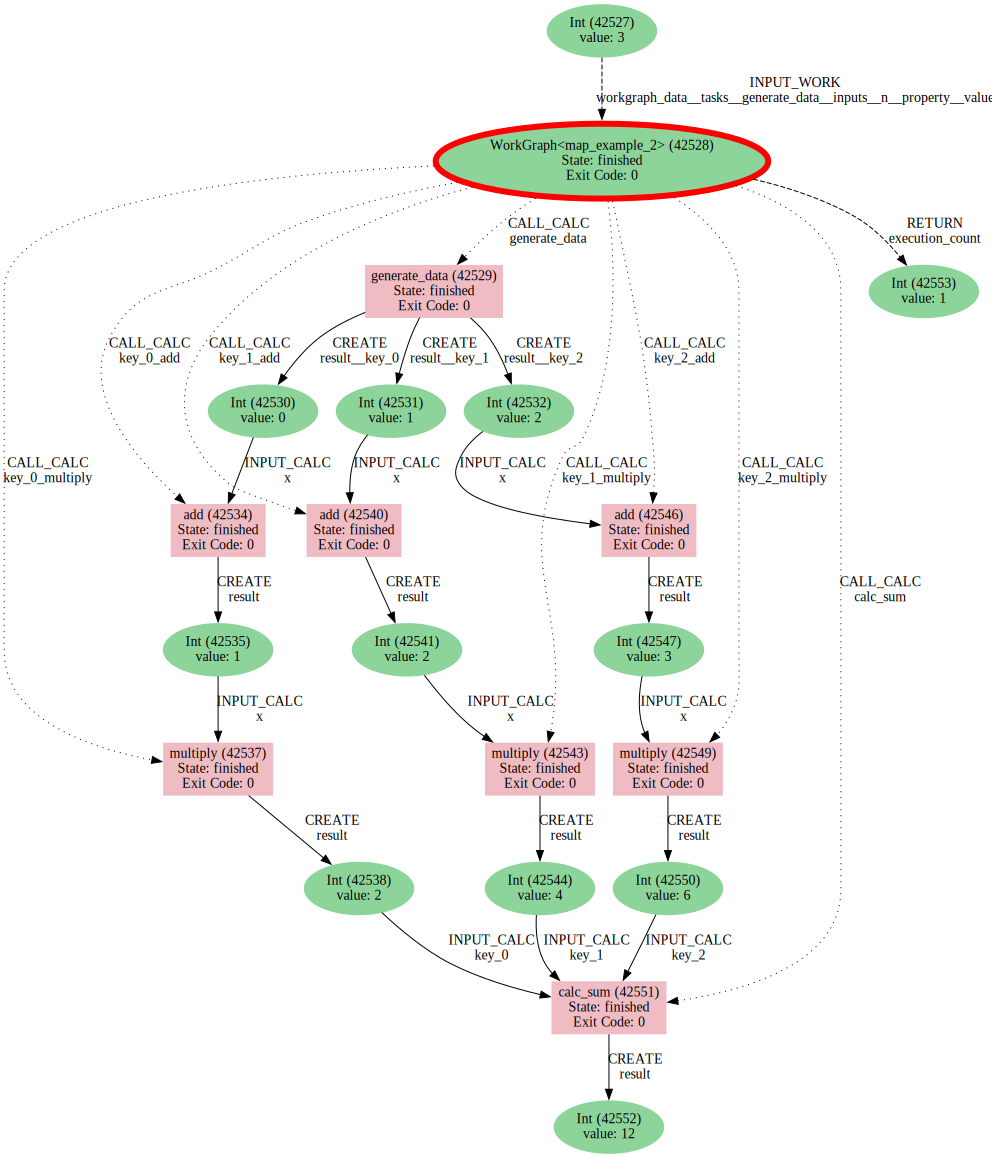

In [6]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

You can see that the outputs of all `add` tasks are linked to the input of the `calc_sum` task.